# REG Capacity vs. Demand

In [1]:
from wimbledon.vis import DataHandlers

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import seaborn as sns
sns.set() # use seaborn's default formatting

In [2]:
start_date = pd.datetime(2017,4,1)
end_date = pd.datetime(2022,3,31)

today = pd.datetime(2019,5,22)

resample_freq = 'MS'

### Capacity (from file)

In [3]:
# Load capacity data exported from previous spreadsheet planner 14 May 2019
capacity = pd.read_csv('../data/reg_capacity.csv', index_col='Month')
capacity = capacity.T
capacity.index = pd.to_datetime(capacity.index, format='%b-%y')
capacity = capacity.loc[start_date:end_date]
capacity[1:10]

Month,REG Permanent capacity,REG FTC capacity,REG Associate capacity,University Partner capacity,Total capacity
2017-05-01,4.5,0.0,0.0,0.0,4.5
2017-06-01,5.5,0.0,0.0,0.0,5.5
2017-07-01,5.5,0.0,0.0,0.0,5.5
2017-08-01,5.5,0.0,0.0,0.0,5.5
2017-09-01,5.5,0.0,0.0,0.0,5.5
2017-10-01,6.0,0.0,0.0,0.0,6.0
2017-11-01,7.0,0.0,0.0,0.0,7.0
2017-12-01,8.5,0.0,0.0,0.0,8.5
2018-01-01,10.0,0.0,0.0,0.0,10.0


### Demand (from Forecast)

In [4]:
fc = DataHandlers.Forecast()

Enpoint: whoami | Time: 0.4465202049999999 | Cache: False
Enpoint: people/460554 | Time: 0.4321714849999998 | Cache: False

AUTHENTICATED USER:
Jack Roberts jroberts@turing.ac.uk

CLIENTS
Enpoint: clients | Time: 0.43563301799999987 | Cache: False
PROJECTS
Enpoint: projects | Time: 0.693481443 | Cache: False
ROLES
Enpoint: roles | Time: 0.4862499229999999 | Cache: False
PEOPLE
Enpoint: people | Time: 0.5881284929999997 | Cache: False
PLACEHOLDERS
Enpoint: placeholders | Time: 0.4373484940000001 | Cache: False
MILESTONES
Enpoint: milestones | Time: 0.42328411 | Cache: False
ASSIGNMENTS
Enpoint: assignments | Time: 0.676092583 | Cache: False
DONE! (4.7s)


In [5]:
# Get totals for REG management, development and support clients
research_support_idx = 745541
reg_management_idx = 745540
reg_dev_idx = 868971

research_support_projs = fc.projects[fc.projects.client_id==research_support_idx].index
reg_management_projs = fc.projects[fc.projects.client_id==reg_management_idx].index
reg_dev_projs = fc.projects[fc.projects.client_id==reg_dev_idx].index

research_support_reqs = fc.project_confirmed[research_support_projs].sum(axis=1)
reg_management_reqs = fc.project_confirmed[reg_management_projs].sum(axis=1)
reg_dev_reqs = fc.project_confirmed[reg_dev_projs].sum(axis=1)

In [6]:
# Get totals for unconfirmed and deferred projects
unconfirmed = fc.placeholder_totals[26903] + fc.placeholder_totals[26910]
unconfirmed = unconfirmed.resample(resample_freq).mean() 

deferred = fc.placeholder_totals[26905]
deferred = deferred.resample(resample_freq).mean() 

In [7]:
# Get overall totals
project_confirmed = fc.project_confirmed.sum(axis=1)
project_confirmed = project_confirmed - reg_management_reqs - reg_dev_reqs - research_support_reqs

reqs = pd.DataFrame({'Confirmed projects':project_confirmed,
                     'REG Management':reg_management_reqs,
                     'REG Development':reg_dev_reqs,
                     'Research Support':research_support_reqs})

reqs = DataHandlers.select_date_range(reqs, start_date, end_date, drop_zero_cols=False)

reqs = reqs.resample(resample_freq).mean()

#FUDGE: force historical demand to match capacity
"""
reqs.loc[pd.datetime(2017,4,1),'Confirmed projects'] = 4.0
reqs.loc[pd.datetime(2017,5,1),'Confirmed projects'] = 4.5
reqs.loc[pd.datetime(2017,6,1),'Confirmed projects'] = 5.5
reqs.loc[pd.datetime(2017,7,1),'Confirmed projects'] = 5.5
reqs.loc[pd.datetime(2017,8,1),'Confirmed projects'] = 5.5
reqs.loc[pd.datetime(2017,9,1),'Confirmed projects'] = 5.5
reqs.loc[pd.datetime(2017,10,1),'Confirmed projects'] = 6
reqs.loc[pd.datetime(2017,11,1),'Confirmed projects'] = 7
reqs.loc[pd.datetime(2017,12,1),'Confirmed projects'] = 8.5
reqs.loc[pd.datetime(2018,1,1),'Confirmed projects'] = 10
reqs.loc[pd.datetime(2018,2,1),'Confirmed projects'] = 10
reqs.loc[pd.datetime(2018,3,1),'Confirmed projects'] = 10
reqs.loc[pd.datetime(2018,4,1),'Confirmed projects'] = 10.5
"""

reqs['Confirmed projects'] = reqs['Confirmed projects'] - reqs['REG Management'] - reqs['REG Development'] - reqs['Research Support']

reqs.head()

,Confirmed projects,REG Management,REG Development,Research Support
2017-04-01,23.52875,0.73625,0.00000,0.36875
2017-05-01,23.61125,0.73625,0.00000,0.39000
2017-06-01,22.43375,0.88125,0.50625,0.43500
2017-07-01,22.65125,0.88125,0.50625,0.39000
2017-08-01,22.61375,0.88125,0.50625,0.49250


In [8]:
# dataframe of demands to plot
to_plot = reqs.copy()
to_plot['Projects with funder'] = unconfirmed
to_plot['Deferred projects'] = deferred

# choose plot order (rearrange columns)
to_plot = to_plot[['REG Management',
                   'REG Development',
                   'Research Support',
                   'Confirmed projects',
                   'Projects with funder',
                   'Deferred projects']]

# rename columns
to_plot.columns = ['REG management demand',
                   'REG development demand',
                   'Research support demand',
                   'Confirmed projects demand',
                   'Projects with funder demand',
                   'Deferred projects demand']

to_plot.head(10)

,REG management demand,REG development demand,Research support demand,Confirmed projects demand,Projects with funder demand,Deferred projects demand
2017-04-01,0.73625,0.00000,0.36875,23.528750,0.0,0.0
2017-05-01,0.73625,0.00000,0.39000,23.611250,0.0,0.0
2017-06-01,0.88125,0.50625,0.43500,22.433750,0.0,0.0
2017-07-01,0.88125,0.50625,0.39000,22.651250,0.0,0.0
2017-08-01,0.88125,0.50625,0.49250,22.613750,0.0,0.0
2017-09-01,0.88125,0.50625,0.54625,22.638750,0.0,0.0
2017-10-01,0.92375,0.50625,0.75250,21.638750,0.0,0.0
2017-11-01,0.92375,0.50625,0.80375,21.263750,0.0,0.0
2017-12-01,0.92375,0.50625,1.64125,20.666711,0.0,0.0
2018-01-01,1.14125,0.00000,1.43250,21.151250,0.0,0.0


### Plot

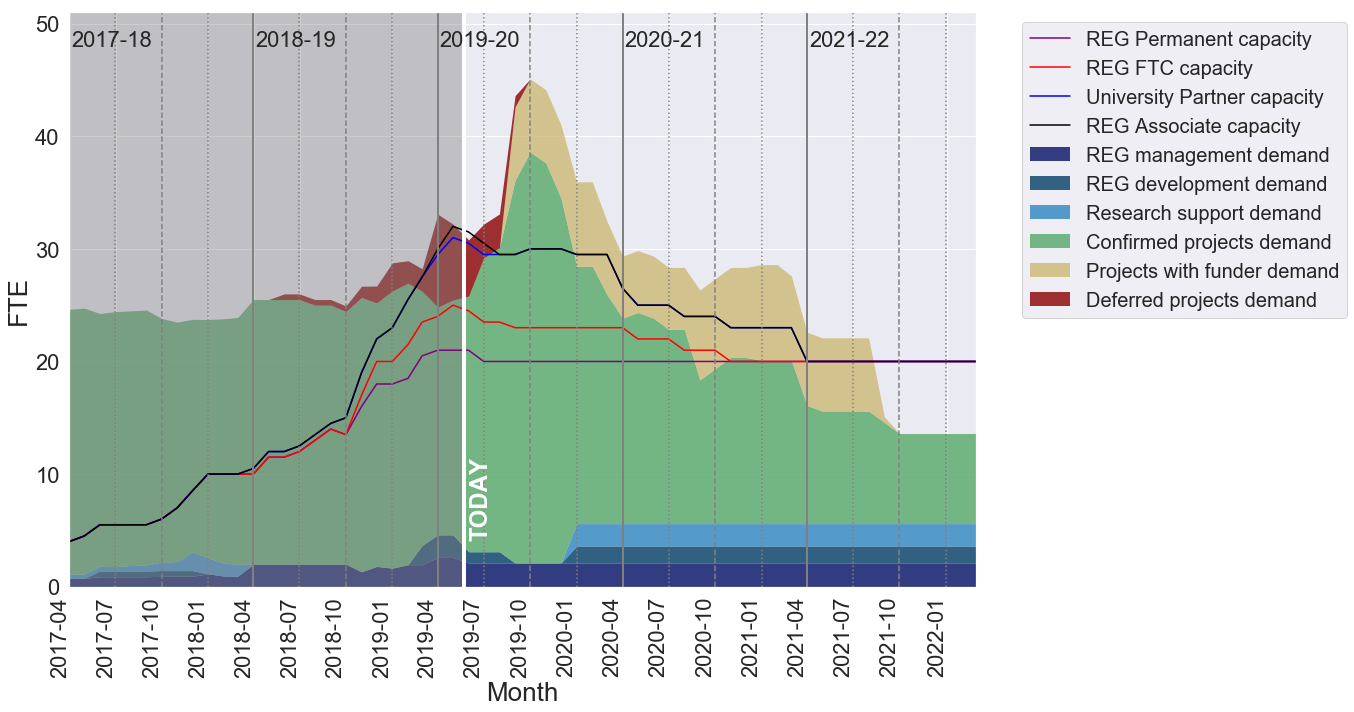

In [9]:
fig = plt.figure(figsize=(19, 10))
ax = fig.gca()

to_plot.plot.area(ax=ax, x_compat=True, rot=90, alpha=0.8, 
                  color=['#041165','#043E65','#2E86C1','g','y','darkred'], 
                  stacked=True, linewidth=0)

# capacity
capacity_plotcols = capacity[['REG Permanent capacity',
                              'REG FTC capacity',
                              'University Partner capacity',
                              'REG Associate capacity']]

capacity_plotcols.cumsum(axis=1).plot(ax=ax, rot=90,linewidth=1.5, color=['purple','red','blue','black'])

# axis limits
xlim = ax.get_xlim()
ylim = (0, 51)

# add quarter separators
quarters = pd.date_range(start=reqs.index.min(),end=reqs.index.max(),freq='QS')
for q in quarters:
    if q.month==4:
        linestyle = '-'
        linewidth = '2'
    
    elif q.month==7:
        linestyle = ':'
        linewidth = '1.5'        
    
    elif q.month==10:
        linestyle = '--'
        linewidth = '1.5'        
    
    elif q.month==1:
        linestyle = ':'
        linewidth = '1.5'
    
    ax.plot([q, q], ylim, linestyle=linestyle, linewidth=linewidth, color='grey')
    
# format labels and titles
ax.set_xticks(reqs.resample('BQS').mean().index.values)
ax.set_xticklabels(reqs.resample('BQS').mean().index.strftime("%Y-%m").values, fontsize=22)
plt.yticks(fontsize=22)

ax.set_ylabel('FTE', fontsize=26)
ax.set_xlabel('Month', fontsize=26)

# legend outside plot
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=20)

# reset axis limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Annotate year (Q1) starts
ax.text(pd.datetime(2017,4,5),48,'2017-18', rotation=0, fontsize=22)
ax.text(pd.datetime(2018,4,5),48,'2018-19', rotation=0, fontsize=22)
ax.text(pd.datetime(2019,4,5),48,'2019-20', rotation=0, fontsize=22)
ax.text(pd.datetime(2020,4,5),48,'2020-21', rotation=0, fontsize=22)
ax.text(pd.datetime(2021,4,5),48,'2021-22', rotation=0, fontsize=22)

# Annotate "today" (today defined in first cell)
ax.plot([today, today], ylim, color='white',linewidth=4)

ax.text(today+pd.Timedelta(12,unit='D'), 10, 'TODAY', 
        rotation=90, fontsize=24, color='white', fontweight='bold')

# grey box over the past
ax.fill([start_date,today,today,start_date],[ylim[0],ylim[0],ylim[1],ylim[1]],'grey', alpha=0.4)

# save figure
plt.tight_layout()
plt.savefig('../data/figs/demand_vs_capacity.png',dpi=300)

In [16]:
fc.project_confirmed
fc.get_id('UNAVAILABLE','project') # 1956786

fc.people_totals


id,399979,408178,408179,408180,408181,408182,408183,408184,408185,408186,...,458587,458588,458589,460554,472253,474864,475627,478638,478799,479080
2016-11-01,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2016-11-02,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2016-11-03,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2016-11-04,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2016-11-07,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2016-11-08,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2016-11-09,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2016-11-10,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2016-11-11,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2016-11-14,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


### Table

In [10]:
project_ids = fc.project_reqs.copy().columns
clients=[]
for project in project_ids:
    client_id = fc.projects.loc[project, 'client_id']
    
    if not np.isnan(client_id):
        clients.append(fc.clients.loc[client_id,'name'])
    else:
        clients.append('NaN')
    

client_meanfte = fc.project_reqs.copy()
client_meanfte = client_meanfte.groupby(clients,axis=1).sum()
client_meanfte = client_meanfte.resample('AS-APR').mean()

client_meanfte = client_meanfte.loc[:, client_meanfte.sum()>0]

client_meanfte = client_meanfte.T
client_meanfte.T.to_csv('../data/figs/demand_per_client.csv')

client_meanfte

AttributeError: 'Forecast' object has no attribute 'project_reqs'

## TODO
### High priority
1. Missing demand for 2017-18 (some from missing data in Forecast, some from April 2017 being dropped by `resample`)
  1. Due to "hut23_actual_effort" spreadsheet not adding up for all people for all months. Plot currently forces capacity to match demand in 2017-18. Should be fixed in Forecast.
1. **Demand / Capacity mismatch 2018-19**
  1. Mostly fixed by cross-checking spreadsheet and Forecast.
1. Capacity lines need extended to April 2022
  1. Done.
1. Can we do a cumulative sum for all capacity except Total to get lines to match original plot?
  1. Done
1. Can we add year labels to mark clearly the span of each financial year.
  1. Done.
1. **Can we be confident 40 FTE is expected long run average? Perhaps x-FTE per programme (based on current less TF demand) + x-FTE per partner uni (support + TF demand + proj-specific demand)**

### Medium priority
1. Missing unconfirmed demand compared to spreadsheet
  1. Done.
1. **Add Scottish Enterprise demand back in time**
1. **Extend Third-party and Edinburgh Safe Haven capacity if demand is solid (check with JH). Should this be TPS or Hut23 project? If Hut23 move REG demand from June to this project.**
1. **Add AI programme demand?**
1. Can we clearly mark 22 May (or 01 June if closest date that's easy to do) as "today" and add a cisual cue to spearate past from future (perhaps a white box over the past or future with alpha to "fade" it)?
  1. Done.

### Low priority
1. Can we separate Hut23 + Research support demand from confirmed and show as "baseline" in another colour below the remaining green confirmed demand (blue perhaps)?
  1. Done
1. Fix duplicate projects in Harvest
1. Split client table by funder.
